In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import gc
import os

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file, print_accracy
from models import *

In [3]:
use_pca = False
use_forieum = False
resume = False
export_csv = True

use_cutout = True
# number of holes to cut out from image
N_HOLES = 1 
# length of the holes
LENGTH = 5

csv_name = 'res_wide_resnet.csv'
checkpoint_name = 'wide_resnet_ckpt.pth'
accuracy_plot_name = 'wide_resnet_acc.png'

BATCH_SIZE = 1500
LR = 1e-1
EPOCHS = 170
momentum = 0.9
weight_decay = 5e-4

best_accuracy = 0.0
epoch = 0
train_acc_plt = []
test_acc_plt = []

In [4]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [5]:
print('==> Preparing data..')


transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: F.pad(x.unsqueeze(0), (4,4,4,4), mode="reflect").squeeze()),
        transforms.ToPILImage(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]) 

transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 

if use_cutout:
    transform_train.transforms.append(Cutout(n_holes=N_HOLES, length=LENGTH))
    
if use_forieum:
    transform_train.transforms.append(remove_high_freq)

if use_pca:
     transform_train.transforms.append(whitening)


==> Preparing data..


In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)

submitdata = np.load("./test/y_test.npy").astype(np.uint8)

submit_images = [ transform_test(img) for img in submitdata]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print("Shape of training data: ")
print(trainX.shape)
print(trainY.shape)

Shape of training data: 
(50000, 3072)
(50000,)


In [8]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))

print("Shape of testing data: ")
print(testX.shape)
print(testY.shape)

Shape of testing data: 
(10000, 3072)
(10000,)


In [9]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))

print("Shape of submitting data: ")    
print(submitX.shape)

Shape of submitting data: 
(12000, 3072)


In [10]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  bird  frog  ship plane truck  frog


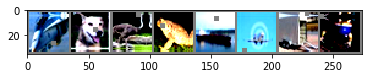

In [11]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images[0:8]))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [12]:
print('==> Building model..')

# net = SeventySevenNet()
# net = ResNet18()
# net = LargeNet()
# net = VGG('VGG19')
# net = WeakerNet21()
# net = PreActResNet18()
net = WideResNet20()
net = net.to(device)

criterion = nn.CrossEntropyLoss()

if resume:
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/' + checkpoint_name)
    net.load_state_dict(checkpoint['net'])
    best_accuracy = checkpoint['acc']
    epoch = checkpoint['epoch']
    train_acc_plt = checkpoint['train_his']
    test_acc_plt = checkpoint['test_his
    
    print("Best Accuracy: " + best_accuracy)
    print("Epoch: " + epoch)
                              
    plt.plot(train_acc_plt, label='Train Accuracy')
    plt.plot(test_acc_plt, label='Test Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.axis([0, EPOCHS, 0, 1])
    plt.legend()
    plt.savefig('./plots/'+accuracy_plot_name)
    plt.show()
    

==> Building model..


In [13]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR divided by 5 at 50th, 100th and 140th epochs"""
    lr_tmp = LR * ((0.2 ** int(epoch >= 50)) * (0.2 ** int(epoch >= 100))* (0.2 ** int(epoch >= 140)))

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_tmp


In [ ]:
gc.collect()

In [14]:
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=momentum, weight_decay=weight_decay)

for i in range(epoch, EPOCHS): 
    time_start = time.time()
#     adjust_learning_rate(optimizer, i+1)
    
    trainNN(net, trainloader, optimizer, criterion,  1)
    
    train_accuracy = cal_accuracy(net, trainloader)
    test_accuracy = cal_accuracy(net, testloader)
    train_acc_plt.append(train_accuracy)
    test_acc_plt.append(test_accuracy)
    
    time_end = (time.time() - time_start)
    
    if test_accuracy > best_accuracy: 
        print('Saving...')
        state = {
            'net': net.state_dict(),
            'acc': test_accuracy,
            'epoch': i+1,
            'train_his': train_acc_plt,
            'test_his': test_acc_plt
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/'+checkpoint_name)
        best_accuracy = test_accuracy
        
    print(f'EPOCH: {i}/{EPOCHS} \t',
          f'Time: {round(time_end)} sec \t', 
          "Train Accuracy:", round(100 * train_accuracy,6), '% \t'
          "Test Accuracy:", round(100 * test_accuracy,6), '% \t'
          "Best Accuracy:", round(100 * best_accuracy,6), '%'
         )
    

Training starts


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.89 GiB already allocated; 4.80 MiB free; 67.12 MiB cached)

In [ ]:
params = list(net.parameters())
print(len(params))

In [ ]:
plt.plot(train_acc_plt, label='Train Accuracy')
plt.plot(test_acc_plt, label='Test Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axis([0, EPOCHS, 0, 1])
plt.legend()
plt.savefig('./plots/'+accuracy_plot_name)
plt.show()

In [ ]:
cal_class_accuracy(net, testloader)

In [ ]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

In [ ]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [ ]:
gc.collect()

In [ ]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]


In [ ]:
images = submit_images[0:30]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(0, 30)))

In [ ]:
if export_csv:
    export_to_file(csv_name, res_labels)